# **Coronavirus tweets-Text Classification**

#### Autore: Martina Cavallucci
#### Email: nome.cognome@studio.unibo.it
#### Release: Gennaio, 2020

*Questo script R esegue un' analisi e una classificazione di testi di tweet durante il perodo di Marzo 2019 e Aprile 2019.
Tali tweet si riferiscono ad un topic specifico: Covid-19.
L'obiettivo è quindi comprendere le relazioni tra i termini utilizzati, e la classificazione dei tweet rispetto al sentiment (Positive, Negative, Neutral).*



---

#### Import delle librerie R e di Text Mining

---




In [ ]:
install.packages("lsa")
install.packages("tm")
install.packages("RWeka")
install.packages("data.table") 
install.packages("checkmate")
install.packages("stringr") 
library(data.table)
library(tidyverse)
library(tm)
library(lsa)
library(RWeka)
library(tidyverse)
if(!require("R.utils"))
  install.packages("R.utils")
library("R.utils")
library(checkmate)
library(stringr)
install.packages("caret") 
library(caret)
install.packages('e1071', dependencies=TRUE)
install.packages("quanteda.textmodels")
library(quanteda.textmodels)
install.packages("stm") 
install.packages("stminsights") 
install.packages("topicmodels") 
library(stm)              # For structural topic models
library(stminsights)      # For visual exploration of STM
library(topicmodels)      # For topicmodels
install.packages("quanteda") 
library(quanteda)

---

#### Import del text set su Github

---


In [2]:
download.file('https://github.com/CavallucciMartina/Coronavirus-tweets-Text-Classification/blob/main/input/Corona_NLP_test.csv.gz?raw=true', 'test.csv.gz') #, method="curl")
gunzip('test.csv.gz')
download.file('https://github.com/CavallucciMartina/Coronavirus-tweets-Text-Classification/blob/main/input/Corona_NLP_train.csv.gz?raw=true', 'train.csv.gz') #, method="curl")
gunzip('train.csv.gz')


---

#### Prima visualizzazione del train set

---


In [ ]:
train <- read.csv("train.csv")
test <- read.csv("test.csv")
head(train)

---

#### Dimensioni del train set e del test set

---


In [ ]:
dim(train)
dim(test)


---

#### Preparazione analisi risultati di Sentiment in Train

---

In [ ]:
library(tidyverse)
districtSentiment = count(train,Sentiment)
districtSentiment[,c(2)]

---

#### Grafico delle percentuali di sentiment nel train set

---

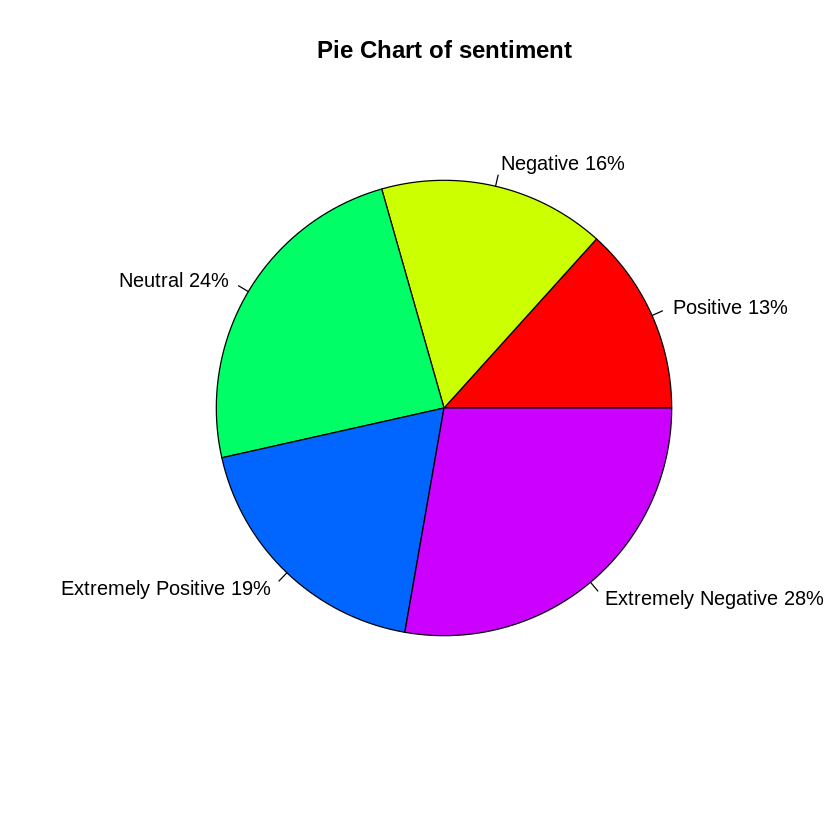

In [6]:
sentiment <- c(districtSentiment[,c(2)]) 
lbls <- c('Positive','Negative','Neutral','Extremely Positive','Extremely Negative')
pct <- round(sentiment/sum(sentiment)*100)
lbls <- paste(lbls, pct) # add percents to labels
lbls <- paste(lbls,"%",sep="") # ad % to labels
pie(sentiment,labels = lbls, col=rainbow(length(lbls)),
   main="Pie Chart of sentiment") 

In [ ]:
y=copy(train$Sentiment )

---

#### Preparazione train per classificazione; trasformazione da 5 classi a 3: Positive, Negative, Neutral

---

In [7]:
new_train = data.frame(
                text = train$OriginalTweet,
                labels = train$Sentiment,
                stringsAsFactors=F)

new_test = data.frame(
                text = test$OriginalTweet,
                labels = test$Sentiment,
                stringsAsFactors=F)


In [8]:
# Data has 5 classes, let's convert them to 3

classes_def <- function(x)
    if (x ==  "Extremely Positive"){
         "2"
    }else if( x == "Extremely Negative"){
         "0"
    }else if(x == "Negative"){
         "0"
    }else if(x ==  "Positive"){
         "2"
    }else {
         "1"
    }


new_train$labels = lapply(new_train$labels, function(x) classes_def(x))
new_test$labels = lapply(new_test$labels, function(x) classes_def(x))
#new_train$labels.value_counts(normalize= True)

---

#### Creazione del corpus

---

In [ ]:
mycorpus <- corpus(new_train)

# Assigns a unique identifier to each text
docvars(mycorpus, "Textno") <-
  sprintf("%02d", 1:ndoc(mycorpus)) 

mycorpus

In [ ]:
# Save statistics in "mycorpus.stats"
mycorpus.stats <- summary(mycorpus)

# And print the statistics of the first 10 observations
head(mycorpus.stats, n = 10)

In [ ]:
kwic(mycorpus, "covid", window=4)

In [ ]:
kwic(mycorpus, "pandemic", window=6)

---

#### Text-preprocessing

---

In [ ]:
# Preprocess the text

# Create tokens
token <-
  tokens(
    mycorpus,
    remove_numbers = TRUE,
    remove_punct = TRUE,
    remove_symbols = TRUE,
    remove_twitter = TRUE,
    remove_url = TRUE,
    remove_hyphens = TRUE,
    include_docvars = TRUE
  )

In [ ]:
# Clean tokens 
token_ungd <- tokens_select(
  token,
  c("[\\d-]", "(http|https)://([^\\s]+)", "<.*?>","#\\w+","@\\w+","\\d+","\\s+", "(s|t)"),
  selection = "remove",
  valuetype = "regex",
  verbose = TRUE
)
toks_nostop <- tokens_select(token_ungd, pattern = stopwords("en"), selection = "remove")
print(toks_nostop)


---

#### Creazione matrice documenti-termini

---

In [ ]:
doc_term_matrix <- dfm(token_ungd,
                       tolower = TRUE,
                       stem = FALSE,
                       remove = stopwords("english"))
head(doc_term_matrix$labels,10)

In [ ]:
doc_term_matrix.trim <-
  dfm_trim(
    doc_term_matrix,
    min_termfreq = 10
  ) 
doc_term_matrix.trim

In [ ]:
# And print the results of the first 10 observations and first 10 features in a DFM
head(dfm_sort(doc_term_matrix.trim, decreasing = TRUE, margin = "both"),
     n = 10,
     nf = 10) 

---

#### Generazione wordcloud

---

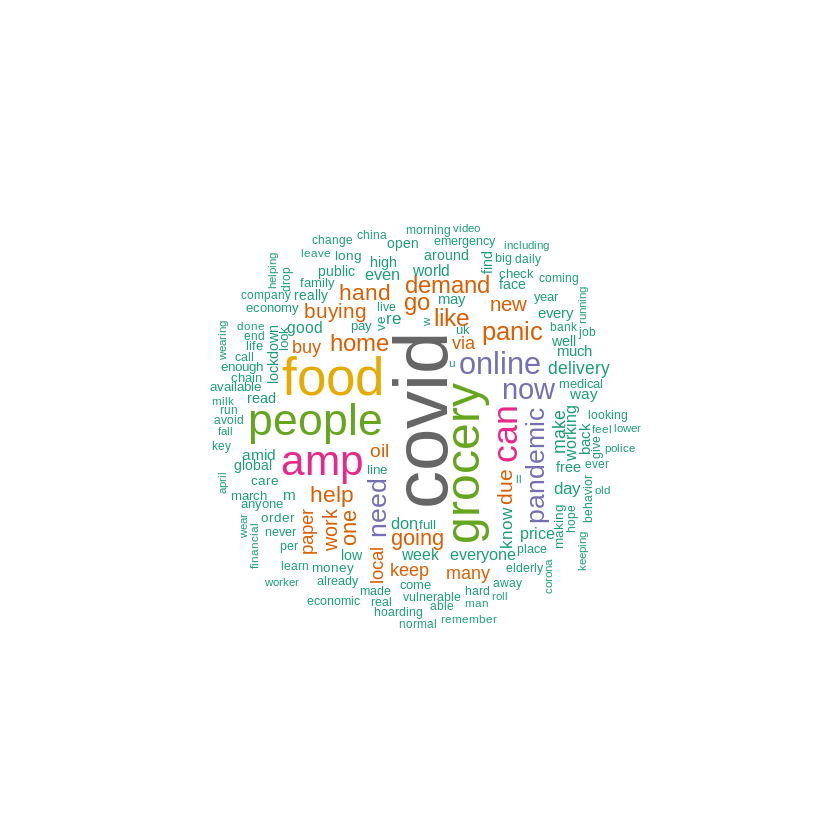

In [66]:
set.seed(100)
textplot_wordcloud(doc_term_matrix.trim, min_count = 300, random_order = FALSE,
                   rotation = .25, 
                   color = RColorBrewer::brewer.pal(8,"Dark2"))

In [ ]:
dict <- featnames(doc_term_matrix)
dict

---

## **Classificazione**

---

Supervised machine learning - Naive Bayes (NB) 

In [ ]:
head(new_train)

In [ ]:
data_corpus <- corpus(new_train, text_field = "text")

In [115]:
# Create docvar with ID
docvars(data_corpus, "id_numeric") <- 1:ndoc(data_corpus)
dfmat_training <- data_corpus %>%
    dfm(remove = stopwords("en"), stem = TRUE)

In [ ]:
test_corpus <- corpus(new_test)
# Get test set (documents not in training_id)
dfmat_test <-dfm(test_corpus)
dfmat_test

In [ ]:
# Train naive Bayes
# The function takes a DFM as the first argument 
tmod_nb <- textmodel_nb(doc_term_matrix.trim, unlist(docvars(dfmat_training, "labels")))
summary(tmod_nb)
# The prior indicates an assumed distribution. 
# Here we choose how frequently the categories occur in our data


In [ ]:
summary(tmod_nb)

In [ ]:
dfmat_matched <- dfm_match(dfmat_test, features = featnames(dfmat_training))


In [ ]:
actual_class <- unlist(dfmat_matched$labels)
predicted_class <- predict(tmod_nb, newdata = dfmat_matched,force = TRUE)
tab_class <- table(actual_class, predicted_class)



In [143]:
confusion <- confusionMatrix(tab_class, mode = "everything")
confusion$table

            predicted_class
actual_class   0   1   2
           0 954 310 369
           1 254 260 105
           2 387 239 920

TODO: classificazione con training cleaning con pre-processing
- Classificatore SVM
- Classificatore Random Forest
- Classificatore K-NN
- Classificatore Rocchio
- CLassificatore Multinomial Bayesian


Provate anche classificazione con bigram